# Compare methods using CD4 Perturb-seq data

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import functools
import numpy as np
import pickle as pkl
from statsmodels.stats.multitest import fdrcorrection
import scipy.stats as stats

In [8]:
data_path = '/data_volume/memento/method_comparison/tfko140/'

In [9]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", ['turquoise', 'slategrey', 'silver'])

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'medium',
         'axes.labelsize': 'medium',
         'axes.titlesize':'medium',
         'figure.titlesize':'medium',
         'xtick.labelsize':'medium',
         'ytick.labelsize':'medium'}
pylab.rcParams.update(params)

### Compute the concordance curve

In [10]:
def safe_fdr(x):
    fdr = np.ones(x.shape[0])
    _, fdr[np.isfinite(x)] = fdrcorrection(x[np.isfinite(x)])
    return fdr

In [11]:
def concordance_curve(ref1, ref2, ref3, ref4, x, k=300):
    overlap = []
    for i in range(1, k+1):
        
        a = len(set(x[:i]) & set(ref1[:i]))
        b = len(set(x[:i]) & set(ref2[:i]))
        c = len(set(x[:i]) & set(ref3[:i]))
        d = len(set(x[:i]) & set(ref4[:i]))
        overlap.append((a+b+c+d)/4)
        
    return np.arange(1, k+1), np.array(overlap)

In [43]:
def concordance_auc(x, y, k=50):
    count = 0
    for i in range(1, k+1):
        
        count += len(set(x[:i]) & set(y[:i]))
    return count / (k*(k+1)/2)

### Read results - paired guides

In [97]:
with open('guide_pairs.pkl', 'rb') as f:
    guides = pkl.load(f)

In [98]:
all_results = []
counter = 0
for target, guide_pair in guides.items():
    
    guide = guide_pair[0]
    
    name_paths_1 = [
            ('edgeR','tfko140.pseudobulk.edger_lrt.{}.{}.csv'.format(target, guide), ['logFC','PValue', 'FDR']),
            ('DESeq2','tfko140.pseudobulk.deseq2_wald.{}.{}.csv'.format(target, guide), ['log2FoldChange','pvalue', 'padj']),
            ('t-test','tfko140.sc.ttest.{}.{}.csv'.format(target, guide), ['logFC','PValue', 'FDR']),
            ('MWU', 'tfko140.sc.mwu.{}.{}.csv'.format(target, guide), ['logFC', 'PValue', 'FDR']),
            # ('MAST', 'tfko140.sc.MAST.{}.{}.csv'.format(target, guidem), ['coef','Pr(>Chisq)', 'fdr']),
            ('memento', 'tfko140.sc.weighted_mean_glm.{}.{}.csv'.format(target, guide), ['logFC','PValue', 'FDR']),

        ]
    guide = guide_pair[1]
    
    name_paths_2 = [
            ('edgeR','tfko140.pseudobulk.edger_lrt.{}.{}.csv'.format(target, guide), ['logFC','PValue', 'FDR']),
            ('DESeq2','tfko140.pseudobulk.deseq2_wald.{}.{}.csv'.format(target, guide), ['log2FoldChange','pvalue', 'padj']),
            ('t-test','tfko140.sc.ttest.{}.{}.csv'.format(target, guide), ['logFC','PValue', 'FDR']),
            ('MWU', 'tfko140.sc.mwu.{}.{}.csv'.format(target, guide), ['logFC', 'PValue', 'FDR']),
            # ('MAST', 'tfko140.sc.MAST.{}.{}.csv'.format(target, guide), ['coef','Pr(>Chisq)', 'fdr']),
            ('memento', 'tfko140.sc.weighted_mean_glm.{}.{}.csv'.format(target, guide), ['logFC','PValue', 'FDR']),
        ]
    results_1 = [pd.read_csv(data_path + path, index_col=0)[cols].rename(columns=dict(zip(cols,['logFC','PValue', 'FDR'])))  for name, path, cols in name_paths_1]
    results_2 = [pd.read_csv(data_path + path, index_col=0)[cols].rename(columns=dict(zip(cols,['logFC','PValue', 'FDR'])))  for name, path, cols in name_paths_2]
        
    combined_result = results_1 + results_2
    gene_lists = [set(res.index) for res in combined_result]
    genes = list(functools.reduce(lambda x,y: x & y, gene_lists))
    
    results_1 = [res.loc[genes].sort_values('FDR') for res in results_1]
    results_2 = [res.loc[genes].sort_values('FDR') for res in results_2]

    scores = [
        (
            name_paths_1[idx][0].replace('_', '\n'), 
            target, 
            concordance_auc(res_1.index, res_2.index),
        ) for idx, (res_1, res_2) in enumerate(zip(results_1, results_2))]
    all_results+=scores

Text(0, 0.5, '')

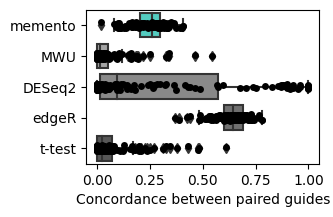

In [99]:
df = pd.DataFrame(
    all_results, 
    columns=['name', 'target', 'auc'])

plt.figure(figsize=(3,2))
pal = [(64/255,224/255,208/255)]+sns.color_palette("Greys", 10)[4:]
sns.boxplot(
    y='name',
    x='auc', 
    data=df, 
    order=[
        'memento',
        'MWU',
        'DESeq2',
        # 'MAST',
        'edgeR',
        't-test',
    ],
    palette=pal)
sns.stripplot(
    y='name',
    x='auc', 
    data=df, 
    order=[
        'memento',
        'MWU',
        'DESeq2',
        # 'MAST',
        'edgeR',
        't-test',
    ],
    color='k')
    
plt.xlabel('Concordance between paired guides')
plt.ylabel('')
# plt.savefig('hbec_alpha_beta_comparison.pdf', bbox_inches='tight')

### Read guides - random guides

In [100]:
all_guides = []
for k,v in guides.items():
    all_guides += v

In [101]:
all_random_results = []
for i in range(200):
    
    guide = np.random.choice(all_guides)
    target = guide.split('.')[0]
    
    name_paths_1 = [
            ('edgeR','tfko140.pseudobulk.edger_lrt.{}.{}.csv'.format(target, guide), ['logFC','PValue', 'FDR']),
            ('DESeq2','tfko140.pseudobulk.deseq2_wald.{}.{}.csv'.format(target, guide), ['log2FoldChange','pvalue', 'padj']),
            ('t-test','tfko140.sc.ttest.{}.{}.csv'.format(target, guide), ['logFC','PValue', 'FDR']),
            ('MWU', 'tfko140.sc.mwu.{}.{}.csv'.format(target, guide), ['logFC', 'PValue', 'FDR']),
            # ('MAST', 'tfko140.sc.MAST.{}.{}.csv'.format(target, guidem), ['coef','Pr(>Chisq)', 'fdr']),
            ('memento', 'tfko140.sc.weighted_mean_glm.{}.{}.csv'.format(target, guide), ['logFC','PValue', 'FDR']),

        ]
    guide2 = np.random.choice(all_guides)
    target2 = guide2.split('.')[0]
    
    name_paths_2 = [
            ('edgeR','tfko140.pseudobulk.edger_lrt.{}.{}.csv'.format(target2, guide2), ['logFC','PValue', 'FDR']),
            ('DESeq2','tfko140.pseudobulk.deseq2_wald.{}.{}.csv'.format(target2, guide2), ['log2FoldChange','pvalue', 'padj']),
            ('t-test','tfko140.sc.ttest.{}.{}.csv'.format(target2, guide2), ['logFC','PValue', 'FDR']),
            ('MWU', 'tfko140.sc.mwu.{}.{}.csv'.format(target2, guide2), ['logFC', 'PValue', 'FDR']),
            # ('MAST', 'tfko140.sc.MAST.{}.{}.csv'.format(target, guide), ['coef','Pr(>Chisq)', 'fdr']),
            ('memento', 'tfko140.sc.weighted_mean_glm.{}.{}.csv'.format(target2, guide2), ['logFC','PValue', 'FDR']),
        ]
    results_1 = [pd.read_csv(data_path + path, index_col=0)[cols].rename(columns=dict(zip(cols,['logFC','PValue', 'FDR'])))  for name, path, cols in name_paths_1]
    results_2 = [pd.read_csv(data_path + path, index_col=0)[cols].rename(columns=dict(zip(cols,['logFC','PValue', 'FDR'])))  for name, path, cols in name_paths_2]
        
    combined_result = results_1 + results_2
    gene_lists = [set(res.index) for res in combined_result]
    genes = list(functools.reduce(lambda x,y: x & y, gene_lists))
    
    results_1 = [res.loc[genes].sort_values('FDR') for res in results_1]
    results_2 = [res.loc[genes].sort_values('FDR') for res in results_2]

    scores = [
        (
            name_paths_1[idx][0].replace('_', '\n'), 
            guide, 
            guide2,
            concordance_auc(res_1.index, res_2.index),
        ) for idx, (res_1, res_2) in enumerate(zip(results_1, results_2))]
    all_random_results+=scores

Text(0, 0.5, '')

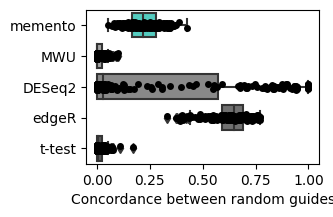

In [102]:
random_df = pd.DataFrame(
    all_random_results, 
    columns=['name', 'g1', 'g2', 'auc'])

plt.figure(figsize=(3,2))
pal = [(64/255,224/255,208/255)]+sns.color_palette("Greys", 10)[4:]
sns.boxplot(
    y='name',
    x='auc', 
    data=random_df, 
    order=[
        'memento',
        'MWU',
        'DESeq2',
        # 'MAST',
        'edgeR',
        't-test',
    ],
    palette=pal)
sns.stripplot(
    y='name',
    x='auc', 
    data=random_df, 
    order=[
        'memento',
        'MWU',
        'DESeq2',
        # 'MAST',
        'edgeR',
        't-test',
    ],
    color='k')
    
plt.xlabel('Concordance between random guides')
plt.ylabel('')
# plt.savefig('hbec_alpha_beta_comparison.pdf', bbox_inches='tight')

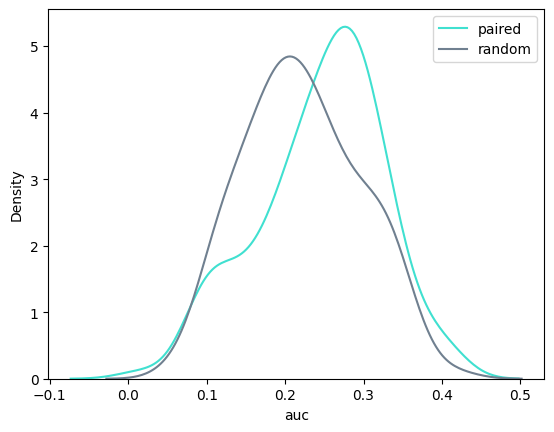

In [113]:
method = 'memento'
x = df.query('name == "{}"'.format(method))['auc']
y = random_df.query('name == "{}"'.format(method))['auc']

sns.kdeplot(x, label='paired')
sns.kdeplot(y, label='random')
plt.legend()

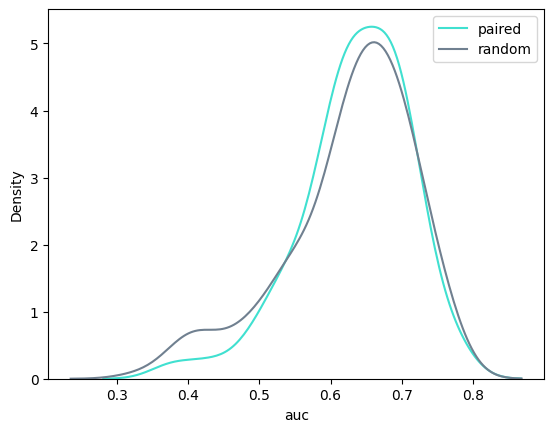

In [116]:
method = 'edgeR'
x = df.query('name == "{}"'.format(method))['auc']
y = random_df.query('name == "{}"'.format(method))['auc']

sns.kdeplot(x, label='paired')
sns.kdeplot(y, label='random')
plt.legend()